In [ ]:
# To do:
# special thank you to ... 
# create markdown sections (including fMRIPrep website, nilearn website etc.) and put references
# improve comments and add print statements to facilitate human understanding
# add error tests
# 
# load afni files
# load atlas(es) for parcellation (standard and/or data-driven)
#
# Nilearn for FC (normal corr, partial corr or tangent space embedding, the latter of which has been shown to be the best?) 
# Graphpype (from Neuropycon) to calculate graph theory metrics
# Analysis of graph metrics, FC and neuropsych scores etc. using PCA, CCA and then SVM, e.g. ?????????
# 
# hypotheses and contrasts
# significance testing and multiple comparisons correction (e.g. Permutation testing or Hierarchical Bayes??)
# 
# Also check the EverNote notes !!!!!

In [ ]:
# This script is to be used on pre-processed fMRI timeseries data 

In [ ]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Copy the script onto the external HDD and try it from there???? !!!!!!!!!!!

In [62]:
import glob
import os
import sys

import pandas as pd
import numpy as np
from numpy import mean
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns

from scipy import stats
from statsmodels.stats.multitest import multipletests
import statannot
from statannot import add_stat_annotation

import xlrd
import itertools

# import nipype.interfaces.fsl as fsl
import nibabel as nib
from nilearn import image
from nilearn import plotting
from nilearn import datasets
from nilearn import input_data
from nilearn.input_data import NiftiMapsMasker
from nilearn.input_data import NiftiLabelsMasker
from nilearn.masking import compute_multi_gray_matter_mask
from nilearn.connectome import ConnectivityMeasure
from nilearn.plotting import plot_design_matrix

import graph_tool.all as gt

from sklearn.preprocessing import StandardScaler

import pickle

In [ ]:
# load an image from a single brain:
fmri_image_folder = "/Volumes/Seagate Dr/PhD/Chapter 2"
fmri_image_path = os.path.join(fmri_image_folder, "F001_B.nii")
fmri_image = nib.load(fmri_image_path)
print(fmri_image.shape)

In [ ]:
# to look at the mean fMRI brain image for a single participant
mean_image = image.mean_img(fmri_image)
plotting.view_img(mean_image, threshold=None)

In [ ]:
full_fmri_image_list = sorted(glob.glob("/Volumes/Seagate Dr/PhD/Chapter 2/*"))
full_fmri_image_list

In [ ]:
# create a mask object and fit it to the whole dataset
# http://nilearn.github.io/modules/generated/nilearn.masking.compute_multi_gray_matter_mask.html
group_mask = compute_multi_gray_matter_mask(full_fmri_image_list)

In [ ]:
plotting.view_img(group_mask, threshold=None)

In [ ]:
# create a NiftiMasker object
brain_masker = input_data.NiftiMasker(group_mask, detrend=True, standardize=True, t_r=2.5, memory='nilearn_cache', memory_level=1, verbose=0)
brain_time_series = brain_masker.fit_transform(fmri_image)

In [ ]:
print("Brain time series shape: (%s, %s)" % brain_time_series.shape)

In [ ]:
plt.plot(brain_time_series[:, [10, 45, 100, 5000, 10000]])
plt.title('Time series from 5 random voxels')
plt.xlabel('Scan number')
plt.ylabel('Normalized signal')
plt.tight_layout()

In [ ]:
brain_time_series.mean()

In [ ]:
# SHOULD I CONVOLVE THE SIGNAL WITH HRF? / Use deconvolution to calculate HRF variability??
# https://pubmed.ncbi.nlm.nih.gov/29656446/
# https://pubmed.ncbi.nlm.nih.gov/30013915/

# check the paper by Holiga et al.,2019 !

# https://nilearn.github.io/auto_examples/04_glm_first_level/plot_hrf.html#sphx-glr-auto-examples-04-glm-first-level-plot-hrf-py


In [ ]:
# https://nilearn.github.io/auto_examples/03_connectivity/plot_seed_to_voxel_correlation.html

voxel_to_voxel_correlations = (np.matmul(brain_time_series.T, brain_time_series) /
                              brain_time_series.shape[0]
                              )

In [ ]:
print("Voxel-to-voxel correlation shape: (%s, %s)" %
      voxel_to_voxel_correlations.shape)
print("Voxel-to-voxel correlation: min = %.3f; max = %.3f" % (
    voxel_to_voxel_correlations.min(), voxel_to_voxel_correlations.max()))

In [ ]:
type(voxel_to_voxel_correlations)

In [ ]:
voxel_to_voxel_correlations

In [ ]:
# threshold at r > 0.25
correlation_matrix = voxel_to_voxel_correlations
correlation_matrix[correlation_matrix < 0.25] = 0
#correlation_matrix

In [ ]:
# # plot a connectivity matrix
# set this to a matrix of your choice
#correlation_matrix = voxel_to_voxel_correlations
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, 
                     # omit the first label as that is the "background" ROI, which wasn't actually used !
                     #labels=harv_oxf_atlas.labels[1:],
                     vmax=1, vmin=-1, colorbar=True)

In [ ]:
unique_elements, counts_elements = np.unique(correlation_matrix, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

In [ ]:
# check a small subset of the data to verify graph generation is accurate

In [ ]:
adj = correlation_matrix[:5,:5]
# np.fill_diagonal(adj, 0) # fill diagonal with zeroes, if it hasn't been done already

In [ ]:
adj

In [ ]:
# https://carlonicolini.github.io/sections/science/2018/09/12/weighted-graph-from-adjacency-matrix-in-graph-tool.html

# to create an undirected, weighted graph

def to_graph_tool(adj):
    g = gt.Graph(directed=False)
    edge_weights = g.new_edge_property('double')
    g.edge_properties['weight'] = edge_weights
    nnz = np.nonzero(np.triu(adj,1))
    nedges = len(nnz[0])
    g.add_edge_list(np.hstack([np.transpose(nnz),np.reshape(adj[nnz],(nedges,1))]),eprops=[edge_weights])
    return g

In [ ]:
gm = to_graph_tool(adj)

In [ ]:
# draw the graph
# check https://www.slideshare.net/moskytw/graphtool-in-practice , slide 46 to adjust weighted edges visualisation
gt.graph_draw(gm, vertex_text=gm.vertex_index#, eprops=[edge_weights]
                          )

In [ ]:
# get the degrees
gm.get_total_degrees([4])

In [ ]:
# use whole dataset for current participant

In [ ]:
np.fill_diagonal(correlation_matrix, 0)
g = to_graph_tool(correlation_matrix)

In [ ]:
# repeat dc steps..

In [ ]:
dc = g.get_total_degrees([i for i in range(brain_time_series.shape[1])])
dc

In [ ]:
print(np.min(dc))
print(np.max(dc))

In [ ]:
# z-score

In [ ]:
# normalise dc values
scaler = StandardScaler()
dc = dc.reshape(-1, 1)
dc_scaled = scaler.fit_transform(dc)

In [ ]:
dc_scaled

In [ ]:
print(np.min(dc_scaled))
print(np.max(dc_scaled))

In [ ]:
dc_scaled_panda = pd.DataFrame(dc_scaled)
dc_scaled_panda.describe()

In [ ]:
# ???????????????????????????????????????????????????????????

# calculate the mean and the SD of the global connectivity and use them to z-score (as in Holiga et al., 2019):

#A previously recommended correlation threshold for DC of r > 0.25 was used for DC
#computation (26). The resulting DC maps were z-scored to the global connectivity (subtracting the mean
#and dividing by the standard deviation) for each subject to minimize the impact of global connectivity
#differences induced by potential confounds (i.e. motion, physiological noise or sequence differences).

mean_glob_conn = np.mean(correlation_matrix)
SD_glob_conn = np.std(correlation_matrix)
dc_z = (dc_scaled - mean_glob_conn) / SD_glob_conn
print(np.min(dc_z))
print(np.max(dc_z))

In [ ]:
dc_z_panda = pd.DataFrame(dc_z)
dc_z_panda.describe()

In [ ]:
# plot significant ones onto a brain atlas, check: 
# https://nilearn.github.io/auto_examples/03_connectivity/plot_seed_to_voxel_correlation.html

In [ ]:
# static atlas
dc_img = brain_masker.inverse_transform(
    dc_scaled.T)
display = plotting.plot_stat_map(dc_img,
                                 threshold=2, vmax=3.5,
                                 #cut_coords=pcc_coords[0],
                                 title="DC"
                                 )

In [ ]:
# interactive atlas
plotting.view_img(dc_img,
                     threshold=2, vmax=3.5,
                     #cut_coords=pcc_coords[0],
                     title="DC"
                     )

In [ ]:
# continue with all participants [choose which ones!!!]

In [ ]:
# check if IQ and Age are significantly different between ASD and TD groups

In [ ]:
# load the excel file (encrypted!!) and the 3rd sheet
# split the dataframe into ASD and TD
# do a t-test on both factors

In [ ]:
# copy all of the FD files into a single folder on the NaN, archive it and download the archive
# get the mean FD vals for each participant and add them to the age/IQ dataframe
# check whether these 3 factors are significantly different between the ASD and TD groups

In [ ]:
# create a dataframe from the text files in the FD folder
# get the mean(and median) values for each participant (N.B. some have 1, some 2 and other all 3 visits!!!!!)

In [ ]:
fd_list = []
fd_file_paths = sorted(glob.glob("/Users/mishodimitrov/Downloads/PhD/Analysis/ARB DC/FD/*.txt"))
fd_file_paths

In [ ]:
# get the session IDs for the whole dataset
root_dir = "/Users/mishodimitrov/Downloads/PhD/Analysis/ARB DC/FD"
fd_session_names_list = [os.path.relpath(os.path.join(dirpath, file), root_dir) for (dirpath, dirnames, filenames) in os.walk(root_dir) for file in filenames]
fd_session_names_list.sort()
fd_session_names_list

In [ ]:
for i in range(len(fd_file_paths)):
        # get an MRI session file
        single_session = pd.read_csv(fd_file_paths[i])
        fd_list.append(single_session)

In [ ]:
len(fd_list)

In [ ]:
# concatenate all pandas files from the fd_list
fd_df = pd.concat(fd_list, axis=1)
fd_df

In [ ]:
# set column names
fd_df.columns = fd_session_names_list
fd_df

In [ ]:
fd_df.columns = fd_df.columns.str.rstrip('_fd_metric.txt')
fd_df

In [ ]:
fd_df_mean = fd_df.mean(axis=0)
fd_df_mean

In [ ]:
fd_df_mean.to_excel("mean_fd.xlsx")

In [ ]:
# pd.options.display.max_rows = 4000

In [ ]:
fd_data = pd.read_excel(r'/Users/mishodimitrov/Downloads/PhD/Analysis/ARB DC/mean_fd_split.xlsx', sheet_name='Sheet3', engine='openpyxl')

In [ ]:
fd_data_td = fd_data.iloc[:,0]
print(fd_data_td)
fd_data_asd = fd_data.iloc[0:73,1] # get only non-NaN values as the NaN values are not actually missing values, rather the asd sample size is just smaller
print(fd_data_asd)

In [ ]:
# check normality of the TD group
k2, p = stats.normaltest(fd_data_td)

alpha = 1e-3

print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution

    print("The null hypothesis can be rejected")

else:

    print("The null hypothesis cannot be rejected")

In [ ]:
#visualise as well
plt.hist(fd_data_td
         #, bins = 20
        )
plt.show()

In [ ]:
# check normality of the ASD group
k2, p = stats.normaltest(fd_data_asd)

alpha = 1e-3

print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution

    print("The null hypothesis can be rejected")

else:

    print("The null hypothesis cannot be rejected")

In [ ]:
#visualise as well
plt.hist(fd_data_asd
         #, bins = 20
        )
plt.show()

In [ ]:
# https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.mannwhitneyu.html
u, prob = stats.mannwhitneyu(fd_data_td, fd_data_asd)
print("u = {:g}".format(u))
print("prob = {:g}".format(prob))
# to get two-sided p-value:
two_sided_prob = 2 * prob
print(two_sided_prob)

In [ ]:
# SIGNIFICANTLY DIFFERENT!!!

In [ ]:
# let's check the age and IQ as well

In [ ]:
# age
df_age_all = pd.read_excel(r'/Users/mishodimitrov/Downloads/PhD/Analysis/ARB DC/ARB_cov_split.xlsx', sheet_name='Age', engine='openpyxl')
df_age_td = df_age_all.iloc[:,0]
print(df_age_td)
df_age_asd = df_age_all.iloc[:27,1]
print(df_age_asd)

In [ ]:
# check normality of the TD group
k2, p = stats.normaltest(df_age_td)

alpha = 1e-3

print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution

    print("The null hypothesis can be rejected")

else:

    print("The null hypothesis cannot be rejected")

In [ ]:
#visualise as well
plt.hist(df_age_td
         #, bins = 20
        )
plt.show()

In [ ]:
# check normality of the TD group
k2, p = stats.normaltest(df_age_asd)

alpha = 1e-3

print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution

    print("The null hypothesis can be rejected")

else:

    print("The null hypothesis cannot be rejected")

In [ ]:
#visualise as well
plt.hist(df_age_asd
         #, bins = 20
        )
plt.show()

In [ ]:
# https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.mannwhitneyu.html
u, prob = stats.mannwhitneyu(df_age_td, df_age_asd)
print("u = {:g}".format(u))
print("prob = {:g}".format(prob))
# to get two-sided p-value:
two_sided_prob = 2 * prob
print(two_sided_prob)

In [ ]:
# SIGNIFICANTLY DIFFERENT!!!

In [ ]:
# IQ
df_iq_all = pd.read_excel(r'/Users/mishodimitrov/Downloads/PhD/Analysis/ARB DC/ARB_cov_split.xlsx', sheet_name='IQ', engine='openpyxl')
df_iq_td = df_iq_all.iloc[:,0]
print(df_iq_td)
df_iq_asd = df_iq_all.iloc[:27,1] # N.B. there is a missing value at the end of the ASD group
print(df_iq_asd)

In [ ]:
# Interpolated missing values

iq_td_mean = df_iq_td.mean()
df_iq_td = df_iq_td.fillna(iq_td_mean)
print(df_iq_td)

iq_asd_mean = df_iq_asd.mean()
df_iq_asd = df_iq_asd.fillna(iq_asd_mean)
print(df_iq_asd)

In [ ]:
# check normality of the TD group
k2, p = stats.normaltest(df_iq_td)

alpha = 1e-3

print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution

    print("The null hypothesis can be rejected")

else:

    print("The null hypothesis cannot be rejected")

In [ ]:
#visualise as well
plt.hist(df_iq_td
         #, bins = 20
        )
plt.show()

In [ ]:
# check normality of the TD group
k2, p = stats.normaltest(df_iq_asd)

alpha = 1e-3

print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution

    print("The null hypothesis can be rejected")

else:

    print("The null hypothesis cannot be rejected")

In [ ]:
#visualise as well
plt.hist(df_age_asd
         #, bins = 20
        )
plt.show()

In [ ]:
#find variance for each group
print(np.var(df_iq_td), np.var(df_iq_asd))

In [ ]:
# we can thus assume equal variance 

In [ ]:
# perform a two-sample t-test on the age data
stats.ttest_ind(a=df_iq_td, b=df_iq_asd, equal_var=True)

In [ ]:
# NOT different!!!

In [ ]:
# !!! In summary, age and in-scanner motion are significantly different between the 2 groups, so must be included
# as covariates in the upcoming analyses !!!

In [ ]:
# load the whole dataset
rootDir = "/Volumes/Seagate Dr/PhD/Chapter 2"
full_fmri_list = [os.path.relpath(os.path.join(dirpath, file), rootDir) for (dirpath, dirnames, filenames) in os.walk(rootDir) for file in filenames]
full_fmri_list

In [ ]:
# path to the fMRI folder
fmri_image_folder = "/Volumes/Seagate Dr/PhD/Chapter 2"

# empty dictionary to be filled with participant IDs and corresponding DC values
dc_vals = {}

# to create an undirected, weighted graph
def to_graph_tool(adj):
    g = gt.Graph(directed=False)
    edge_weights = g.new_edge_property('double')
    g.edge_properties['weight'] = edge_weights
    nnz = np.nonzero(np.triu(adj,1))
    nedges = len(nnz[0])
    g.add_edge_list(np.hstack([np.transpose(nnz),np.reshape(adj[nnz],(nedges,1))]),eprops=[edge_weights])
    return g


# to calculate functional connectivity and degree centrality
def calc_dc(fmri_list):
    for i in range(len(fmri_list)):
        # load an image from a single brain:
        fmri_image_path = os.path.join(fmri_image_folder, fmri_list[i])
        fmri_image = nib.load(fmri_image_path)
        print("Participant " + fmri_list[i])
        print("The image dimensions are: " + str(fmri_image.shape))
        
        # create a NiftiMasker object
        brain_masker = input_data.NiftiMasker(group_mask, detrend=True, standardize=True, t_r=2.5, 
                                              memory='nilearn_cache', memory_level=1, verbose=0)
        brain_time_series = brain_masker.fit_transform(fmri_image)
        
        # calculate the correlations between each pair of voxels
        voxel_to_voxel_correlations = (np.matmul(brain_time_series.T, brain_time_series) /
                                      brain_time_series.shape[0])
        print("Correlations calculated.")
        
        # threshold at r > 0.25
        correlation_matrix = voxel_to_voxel_correlations
        correlation_matrix[correlation_matrix < 0.25] = 0
        print("Correlation matrix thresholded.")
        
        # fill diagonal with zeroes
        np.fill_diagonal(correlation_matrix, 0)
        print("Correlation matrix diagonal set to 0.")
        
        # calculate the degree centrality (DC)
        g = to_graph_tool(correlation_matrix)
        dc = g.get_total_degrees([i for i in range(brain_time_series.shape[1])])
        print("DC values calcualted.")
        
        # z-score the DC values
        scaler = StandardScaler()
        dc = dc.reshape(-1, 1)
        dc_scaled = scaler.fit_transform(dc)
        print("DC values z-scored.")

        # add the dc values and their matching participant ID to the dc_vals dictionary
        dc_vals[fmri_list[i]] = dc_scaled
        print("Dictionary updated.")

In [ ]:
small_fmri_list = full_fmri_list[0:2]
small_fmri_list

In [ ]:
calc_dc(full_fmri_list)

In [ ]:
dc_vals

In [ ]:
# save the dictionary to a file
# https://www.quora.com/How-can-I-store-dictionaries-in-Python
# https://pythonspot.com/save-a-dictionary-to-a-file/

f = open("dc_vals.pkl","wb")
pickle.dump(dc_vals,f)
f.close()

In [2]:
# open the dictionary file and assign to a variable
with open("/Users/mishodimitrov/Downloads/PhD/Analysis/ARB DC/dc_vals.pkl", "rb") as f:
    dc_vals = pickle.load(f)

In [ ]:
dc_vals

In [75]:
#np.set_printoptions(threshold=100
                    #sys.maxsize
#                   )

In [ ]:
dc_vals['F001_A']

In [3]:
dc_vals = {x.replace('.nii', ''): v  
     for x, v in dc_vals.items()} 

In [4]:
dc_vals = {x.replace('_', ''): v  
     for x, v in dc_vals.items()} 

In [5]:
dc_vals

{'F001A': array([[-1.41458658],
        [-1.41458658],
        [-1.41458658],
        ...,
        [-1.41458658],
        [-1.41458658],
        [-1.41458658]]),
 'F001B': array([[-1.62235605],
        [-0.37148007],
        [-0.12727541],
        ...,
        [-1.62235605],
        [-1.62235605],
        [-1.62235605]]),
 'F002B': array([[-2.96045937e-02],
        [-2.96045937e-02],
        [-2.96045937e-02],
        ...,
        [ 3.47905907e+01],
        [ 3.37099941e+01],
        [ 3.47818828e+01]]),
 'F002C': array([[-2.54621395e-02],
        [-2.54621395e-02],
        [-2.54621395e-02],
        ...,
        [-1.63502897e-04],
        [ 4.02898000e+01],
        [ 3.90437080e+01]]),
 'F003A': array([[-2.66003272e-02],
        [-2.66003272e-02],
        [-2.66003272e-02],
        ...,
        [ 3.77032061e+01],
        [ 5.05615852e-01],
        [ 3.77337389e+01]]),
 'F003B': array([[-3.05661899e-02],
        [-3.05661899e-02],
        [-3.05661899e-02],
        ...,
        [ 9.952

In [ ]:
# split dc_vals into 6 groups - td_placebo, td_low, td_high, asd_placebo, asd_low, asd_high

In [ ]:
# first, create td_placebo
# sessions to use (double-check these!!!!!!!!!): 
# F002B, F003A, F004B, F005A F006C, F008C, F009C, F010B, F011A, F012B, F014C, F016C, M001A, M002C, M004B, M005B, 
# M006C, M007A, M008A, M009C, M010A, M011B, M012B, M013B, M014A, M015C, M016C, M018B, M020B, M021A, M022A

In [13]:
td_placebo_list = ["F002B", "F003A", "F004B", "F005A", "F006C", "F008C", "F009C", "F010B", "F011A", "F012B", "F014C",
                   "F016C", "M001A", "M002C", "M004B", "M005B", "M006C", "M007A", "M008A", "M009C", "M010A", "M011B", 
                   "M012B", "M013B", "M014A", "M015C", "M016C", "M020B", "M021A", "M022A"]
len(td_placebo_list)

30

In [31]:
for k in td_placebo_list:
    print(k)

F002B
F003A
F004B
F005A
F006C
F008C
F009C
F010B
F011A
F012B
F014C
F016C
M001A
M002C
M004B
M005B
M006C
M007A
M008A
M009C
M010A
M011B
M012B
M013B
M014A
M015C
M016C
M020B
M021A
M022A


In [32]:
td_placebo_dc = list((dc_vals[k]) for k in td_placebo_list 
                                        if k in dc_vals) 

In [33]:
td_placebo_dc

[array([[-2.96045937e-02],
        [-2.96045937e-02],
        [-2.96045937e-02],
        ...,
        [ 3.47905907e+01],
        [ 3.37099941e+01],
        [ 3.47818828e+01]]),
 array([[-2.66003272e-02],
        [-2.66003272e-02],
        [-2.66003272e-02],
        ...,
        [ 3.77032061e+01],
        [ 5.05615852e-01],
        [ 3.77337389e+01]]),
 array([[-2.98936424e-02],
        [-2.98936424e-02],
        [-2.98936424e-02],
        ...,
        [ 3.43816737e+01],
        [ 3.43749132e+01],
        [ 1.02518556e+00]]),
 array([[-2.37940571e-02],
        [-2.37940571e-02],
        [-2.37940571e-02],
        ...,
        [-1.55364912e-02],
        [ 4.29761278e+01],
        [ 1.31535452e+00]]),
 array([[-6.84746854e-03],
        [-6.84746854e-03],
        [-6.84746854e-03],
        ...,
        [-6.84746854e-03],
        [ 1.47031523e+02],
        [ 1.45033553e+02]]),
 array([[-0.0323535 ],
        [-0.0323535 ],
        [-0.0323535 ],
        ...,
        [30.55345914],
        [ 

In [ ]:
# then, create asd_placebo
# sessions to use (double-check these!!!!!!!!!): 
# F103A, F107A, F109C, F110B, M101A, M102C, M103C, M105B, M106C, M107A, M108A, M109C, M110A, M111B, M112B, M113B, 
# M114A, M115C, M117C, M118B, M119C, M120B, M121A, M130C

In [34]:
asd_placebo_list = ["F103A", "F107A", "F109C", "F110B", "M101A", "M102C", "M103C", "M105B", "M106C", "M107A", "M108A",
                   "M109C", "M110A", "M111B", "M112B", "M113B", "M114A", "M115C", "M117C", "M118B", "M119C", "M120B", 
                   "M121A", "M130C"]
len(asd_placebo_list)

24

In [35]:
asd_placebo_dc = list((dc_vals[k]) for k in asd_placebo_list 
                                        if k in dc_vals) 

In [36]:
asd_placebo_dc

[array([[-1.09624150e-02],
        [-1.09624150e-02],
        [-1.09624150e-02],
        ...,
        [ 9.37296895e+01],
        [ 1.23875902e+00],
        [ 2.91505363e+00]]),
 array([[-4.99128082e-03],
        [-4.99128082e-03],
        [-4.99128082e-03],
        ...,
        [-4.99128082e-03],
        [ 2.06427052e+02],
        [ 6.46604948e+00]]),
 array([[-5.29840366e-03],
        [-5.29840366e-03],
        [-5.29840366e-03],
        ...,
        [ 2.32075164e-02],
        [ 6.63905108e+00],
        [ 6.54289006e+00]]),
 array([[-0.0085148 ],
        [-0.0085148 ],
        [-0.0085148 ],
        ...,
        [ 0.01248737],
        [ 1.56633196],
        [ 0.00935409]]),
 array([[-2.70808817e-02],
        [-2.70808817e-02],
        [-2.70808817e-02],
        ...,
        [ 3.71398823e+01],
        [ 4.72366538e-01],
        [ 3.71415721e+01]]),
 array([[-9.79147193e-03],
        [-9.79147193e-03],
        [-9.79147193e-03],
        ...,
        [ 1.03703473e+02],
        [ 1.392276

In [ ]:
# A > B contrast - just a test
# https://nilearn.github.io/auto_examples/05_glm_second_level/plot_second_level_two_sample_test.html

In [41]:
from nilearn.datasets import fetch_localizer_contrasts
n_subjects = 16
sample_vertical = fetch_localizer_contrasts(
    ["vertical checkerboard"], n_subjects, get_tmaps=True)
sample_horizontal = fetch_localizer_contrasts(
    ["horizontal checkerboard"], n_subjects, get_tmaps=True)
second_level_input = sample_vertical['cmaps'] + sample_horizontal['cmaps']

/opt/anaconda3/envs/Project_2_ARB/lib/python3.9/site-packages/numpy/lib/npyio.py:2349: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


<AxesSubplot:label='conditions', ylabel='scan number'>

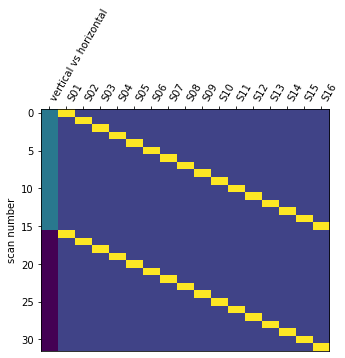

In [42]:
#We define the input maps and the design matrix for the second level model and fit it.
second_level_input = sample_vertical['cmaps'] + sample_horizontal['cmaps']

#Next, we model the effect of conditions (sample 1 vs sample 2).

condition_effect = np.hstack(([1] * n_subjects, [- 1] * n_subjects))

#Subsequently, we can model the subject effect: each subject is observed in sample 1 and sample 2.

subject_effect = np.vstack((np.eye(n_subjects), np.eye(n_subjects)))
subjects = ['S%02d' % i for i in range(1, n_subjects + 1)]

#We then assemble those in a design matrix and

design_matrix = pd.DataFrame(
    np.hstack((condition_effect[:, np.newaxis], subject_effect)),
    columns=['vertical vs horizontal'] + subjects)

#plot the design_matrix.
plot_design_matrix(design_matrix)

In [37]:
second_level_input = asd_placebo_dc + td_placebo_dc

In [38]:
second_level_input

[array([[-1.09624150e-02],
        [-1.09624150e-02],
        [-1.09624150e-02],
        ...,
        [ 9.37296895e+01],
        [ 1.23875902e+00],
        [ 2.91505363e+00]]),
 array([[-4.99128082e-03],
        [-4.99128082e-03],
        [-4.99128082e-03],
        ...,
        [-4.99128082e-03],
        [ 2.06427052e+02],
        [ 6.46604948e+00]]),
 array([[-5.29840366e-03],
        [-5.29840366e-03],
        [-5.29840366e-03],
        ...,
        [ 2.32075164e-02],
        [ 6.63905108e+00],
        [ 6.54289006e+00]]),
 array([[-0.0085148 ],
        [-0.0085148 ],
        [-0.0085148 ],
        ...,
        [ 0.01248737],
        [ 1.56633196],
        [ 0.00935409]]),
 array([[-2.70808817e-02],
        [-2.70808817e-02],
        [-2.70808817e-02],
        ...,
        [ 3.71398823e+01],
        [ 4.72366538e-01],
        [ 3.71415721e+01]]),
 array([[-9.79147193e-03],
        [-9.79147193e-03],
        [-9.79147193e-03],
        ...,
        [ 1.03703473e+02],
        [ 1.392276

In [50]:
len(second_level_input[1])

108

In [ ]:
# https://nilearn.github.io/modules/generated/nilearn.plotting.plot_design_matrix.html

In [ ]:
# https://wiki.biac.duke.edu/biac:analysis:resting_pipeline

In [64]:
# First contrast - ASD - TD (Placebo)
condition_effect = np.hstack(([1] * len(asd_placebo_dc), [- 1] * len(td_placebo_dc)))
condition_effect

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1])

In [ ]:
# have the condition effect horizontally and the participant effects vertically??

In [81]:
pd.DataFrame(np.hstack(condition_effect[:, np.newaxis])) # should stack them next to each other instead???????

,0
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,1


In [82]:
subject_effect = np.vstack((np.eye(len(asd_placebo_dc)), np.eye(len(td_placebo_dc))))

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 24 and the array at index 1 has size 30

In [73]:
#We then assemble those in a design matrix and

design_matrix = pd.DataFrame(
    np.hstack(condition_effect[:, np.newaxis]),
    columns = asd_placebo_list + td_placebo_list
)

#plot the design_matrix.
plot_design_matrix(design_matrix)

ValueError: Shape of passed values is (54, 1), indices imply (54, 54)

In [ ]:
# add the covariates to the design matrix

In [ ]:
# test the contrast

In [ ]:
# multiple comparisons correction

In [ ]:
# Generate summary statistics for both groups (ASD, TD) and all 3 drug conditions??????

In [ ]:
# plot DC results using the brain atlas coordinates and anatomical labels.. use nilearn plotting????????? (https://nilearn.github.io/auto_examples/03_connectivity/plot_seed_to_voxel_correlation.html)

In [ ]:
# Get all the non-imaging data - clean it up, pre-process it, scale it etc.

In [ ]:
# PCA (and CCA????) for dimensionality reduction 

In [ ]:
# Set-up the different contrasts

In [ ]:
# Assess the statistical significance